In [1]:
# Import useful libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
import sklearn.metrics as metrics
import numpy as np
from tqdm import tqdm
from sklearn import preprocessing, linear_model
from numpy import mean, std
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
df= pd.read_csv('MICRODADOS_ENEM_2019.csv', sep=';', encoding='latin-1')
print(df.shape[0])

5095270


In [3]:
# Get the percentage of missing data from each column
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df

,percent_missing
NU_INSCRICAO,0.000000
NU_ANO,0.000000
CO_MUNICIPIO_RESIDENCIA,0.000000
NO_MUNICIPIO_RESIDENCIA,0.000000
CO_UF_RESIDENCIA,0.000000
SG_UF_RESIDENCIA,0.000000
NU_IDADE,0.000000
TP_SEXO,0.000000
TP_ESTADO_CIVIL,0.000000
TP_COR_RACA,0.000000


In [4]:
# Label Encoder
le = preprocessing.LabelEncoder()
# Encode each column (with the exception of the target column and one encoded column)
for column in range(1,26):
    # This column is already encoded
    if column in (5,6):
        continue
    if column < 10:
        df[f'Q00{column}'] = le.fit_transform(df[f'Q00{column}'])
    else:
        df[f'Q0{column}'] = le.fit_transform(df[f'Q0{column}'])
    

In [5]:
# List all the columns that will be used
temp_list = [ f'Q00{column}' for column in range(1,10)] 
temp_list2 = [ f'Q0{column}' for column in range(10,26)] 
columns= temp_list + temp_list2
df=df[columns]
print(df.head())

   Q001  Q002  Q003  Q004  Q005 Q006  Q007  Q008  Q009  Q010  ...  Q016  Q017  \
0     3     4     0     0     7    B     0     1     2     0  ...     0     0   
1     3     4     0     0     5    B     0     1     2     0  ...     0     0   
2     7     4     0     3     3    C     3     4     4     2  ...     1     0   
3     3     3     0     1     3    C     0     1     2     0  ...     0     0   
4     1     2     0     0     5    C     0     2     1     0  ...     0     0   

   Q018  Q019  Q020  Q021  Q022  Q023  Q024  Q025  
0     0     2     1     0     3     0     1     0  
1     0     1     1     0     1     0     0     0  
2     0     3     1     1     3     0     2     1  
3     0     2     0     0     3     0     0     0  
4     0     1     0     0     3     0     0     0  

[5 rows x 25 columns]


In [6]:
# Copy df
df_copy=df
# Rename target column
df_copy.rename(columns={"Q006": "target"}, inplace=True)
# Correct the indexes
df_copy = df_copy.reindex(sorted(df.columns), axis=1)
df_copy.head()

,Q001,Q002,Q003,Q004,Q005,Q007,Q008,Q009,Q010,Q011,...,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,target
0,3,4,0,0,7,0,1,2,0,0,...,0,0,2,1,0,3,0,1,0,B
1,3,4,0,0,5,0,1,2,0,0,...,0,0,1,1,0,1,0,0,0,B
2,7,4,0,3,3,3,4,4,2,0,...,0,0,3,1,1,3,0,2,1,C
3,3,3,0,1,3,0,1,2,0,0,...,0,0,2,0,0,3,0,0,0,C
4,1,2,0,0,5,0,2,1,0,1,...,0,0,1,0,0,3,0,0,0,C


In [7]:
# If family Wage <= 2 Minimum Wage in 2019
df_copy['target'].replace(['A', 'B'], 1, inplace=True)

# If family Wage <= 4 Minimum Wage in 2019
df_copy['target'].replace(['C', 'D', 'E', 'F', 'G'], 2, inplace=True)

# If family Wage <= 10 Minimum Wage in 2019
df_copy['target'].replace(['H', 'I', 'J', 'K', 'L','M'], 3, inplace=True)

# If family Wage <= 20 Minimum Wage in 2019
df_copy['target'].replace(['N', 'O', 'P'], 4, inplace=True)

# If family Wage > 20 Minimum Wage in 2019
df_copy['target'].replace(['Q'], 5, inplace=True)

# Print head
df_copy.head()

,Q001,Q002,Q003,Q004,Q005,Q007,Q008,Q009,Q010,Q011,...,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,target
0,3,4,0,0,7,0,1,2,0,0,...,0,0,2,1,0,3,0,1,0,1
1,3,4,0,0,5,0,1,2,0,0,...,0,0,1,1,0,1,0,0,0,1
2,7,4,0,3,3,3,4,4,2,0,...,0,0,3,1,1,3,0,2,1,2
3,3,3,0,1,3,0,1,2,0,0,...,0,0,2,0,0,3,0,0,0,2
4,1,2,0,0,5,0,2,1,0,1,...,0,0,1,0,0,3,0,0,0,2


In [8]:
df_copy_= df_copy.sample(n=1000000, random_state=42)

In [9]:
# Split the data with 25% of it in the test size
train, test = train_test_split(df_copy_, test_size=0.25)
all_columns = list(df_copy.columns)
x_vars = all_columns[:24]

# Train Set
X = train[x_vars]
y = train['target']

# Test set 
test_X = test[x_vars]
test_y = test['target']

 17%|█▋        | 1/6 [50:05<4:10:25, 3005.02s/it]

>0.0001 0.666 (0.001)


 33%|███▎      | 2/6 [2:06:06<3:51:27, 3471.88s/it]

>0.0010 0.671 (0.002)


 50%|█████     | 3/6 [3:46:23<3:31:46, 4235.40s/it]

>0.0100 0.672 (0.002)


 67%|██████▋   | 4/6 [5:34:54<2:43:56, 4918.20s/it]

>0.1000 0.672 (0.002)


 83%|████████▎ | 5/6 [7:26:29<1:30:51, 5451.21s/it]

>0.5000 0.672 (0.002)


100%|██████████| 6/6 [9:40:05<00:00, 5800.89s/it]  

>1.0000 0.672 (0.002)


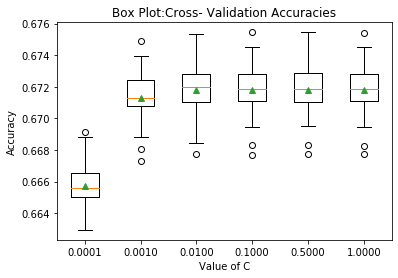

<Figure size 1080x432 with 0 Axes>

In [10]:
# get a list of models to evaluate
def model_candidate():
    models = dict()
    for C in [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]:
        # create name for model
        key = '%.4f' % C
        # turn off penalty in some cases
        models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=C, max_iter=1000)
    return models

# evaluate a give model using cross-validation
def model_evaluate(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    # evaluate the model
    results = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # Return the results
    return results

# get the models candidates to evaluate
models = model_candidate()
# evaluate the models and store results
results = []
names = []
for name, model in tqdm(models.items()):
    # evaluate the model and collect the results
    results = model_evaluate(model, X, y)
    # store the results
    results.append(results)
    names.append(name)
    # Summarize giving the mean and Standard deviation of results
    print('>%s %.3f (%.3f)' % (name, mean(results), std(results)))
    
# plot model performance for comparison
plt.title('Box Plot:Cross- Validation Accuracies')
plt.boxplot(results, labels=names, showmeans=True)
plt.xlabel('Value of C')
plt.ylabel('Accuracy')
plt.figure(figsize=(15, 6))
plt.show()
# Adapted from https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/

In [11]:
# Fit the logistic regression with the "optimized" parameter
log_reg = linear_model.LogisticRegression(C=0.5, penalty = 'l2', max_iter=1000).fit(X,y)

# Store predictions
y_pred = log_reg.predict(X)

print('Training Accuracy score: ', metrics.accuracy_score(y,y_pred))

Training Accuracy score:  0.6719106666666667


In [12]:
log_reg.coef_

array([[-1.28185062e-01, -1.95758258e-01, -2.04519601e-01,
        -2.19386140e-01,  1.17402113e-01, -2.49171392e-01,
        -5.66657455e-01, -1.02177285e-01, -1.10993053e+00,
         1.26913993e-02,  1.91578090e-02, -1.89284115e-01,
        -5.88680749e-01, -9.39286241e-02, -3.46133214e-01,
         4.98323714e-02, -6.18339855e-01, -1.96265626e-01,
         1.33630207e-01, -8.24730490e-01, -4.06075160e-01,
        -4.73831570e-01, -7.74199146e-01, -7.75024718e-01],
       [-1.41605213e-01, -1.42650422e-01, -1.84197784e-01,
        -1.27369207e-01,  1.21586828e-01, -3.74282826e-01,
        -3.97707478e-01, -8.06810970e-02, -2.95038183e-01,
         1.42431851e-01,  1.84715473e-01, -4.32462663e-02,
        -2.55370292e-02, -1.18776377e-01,  1.05398886e-02,
        -3.15886564e-01, -2.70892948e-01, -6.62090680e-02,
        -9.05682144e-02, -4.61411556e-01, -4.07620648e-02,
        -1.46143143e-02, -2.78905565e-01, -4.50710787e-01],
       [-6.12478728e-02,  7.53267503e-02, -8.41062138e

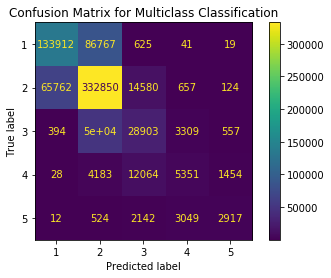

<Figure size 1080x432 with 0 Axes>

In [13]:
# define confusion matrix
cm = confusion_matrix(y, y_pred, labels=log_reg.classes_)
# define confusion matrix display 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
# plot display
disp.plot()
plt.title('Confusion Matrix for Multiclass Classification')
plt.figure(figsize=(15, 6))
plt.show()

In [14]:
# Store predictions
y_pred = log_reg.predict(test_X)
print('Test Accuracy score: ', metrics.accuracy_score(test_y, y_pred))

Test Accuracy score:  0.673072


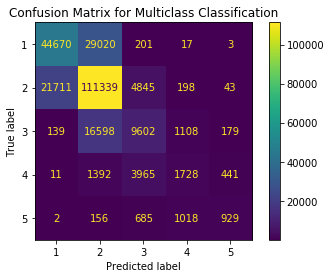

<Figure size 1080x432 with 0 Axes>

In [15]:
# define confusion matrix
cm = confusion_matrix(y, y_pred, labels=log_reg.classes_)
# define confusion matrix display 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
# plot display
disp.plot()
plt.title('Confusion Matrix for Multiclass Classification')
plt.figure(figsize=(15, 6))
plt.show()

In [16]:
rfe = RFE(log_reg, step=1, verbose = 0, n_features_to_select= 1/3)
rfe = rfe.fit(X, y)
remove=[]
for i in range(X.shape[1]):
    if rfe.ranking_[i] != 1:
        remove.append(f'{x_vars[i]}')
    else:
        continue
print(f'Features to be removed: {remove}')

Features to be removed: ['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q009', 'Q011', 'Q012', 'Q013', 'Q015', 'Q016', 'Q017', 'Q019', 'Q020', 'Q022', 'Q023']


In [17]:
df_copy_.drop(remove, axis=1, inplace=True)

In [18]:
# Split the data with 25% of it in the test size
train, test = train_test_split(df_copy_, test_size=0.25)
all_columns = list(df_copy_.columns)
x_vars = all_columns[:8]

X = train[x_vars]
y = train['target']

test_X = test[x_vars]
test_y = test['target']

 17%|█▋        | 1/6 [07:09<35:48, 429.70s/it]

>0.0001 0.648 (0.001)


 33%|███▎      | 2/6 [23:19<39:26, 591.64s/it]

>0.0010 0.654 (0.002)


 50%|█████     | 3/6 [46:42<41:45, 835.24s/it]

>0.0100 0.654 (0.002)


 67%|██████▋   | 4/6 [1:14:08<35:56, 1078.28s/it]

>0.1000 0.654 (0.002)


 83%|████████▎ | 5/6 [1:42:18<21:01, 1261.76s/it]

>0.5000 0.654 (0.002)


100%|██████████| 6/6 [2:10:43<00:00, 1307.18s/it]

>1.0000 0.654 (0.002)


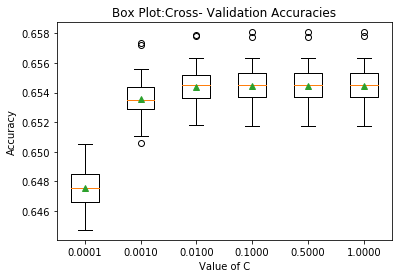

<Figure size 1080x432 with 0 Axes>

In [19]:
# get a list of models to evaluate
def model_candidate():
    models = dict()
    for C in [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]:
        # create name for model
        key = '%.4f' % C
        # turn off penalty in some cases
        models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=C, max_iter=1000)
    return models

# evaluate a give model using cross-validation
def model_evaluate(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    # evaluate the model
    results = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # Return the results
    return results

# get the models candidates to evaluate
models = model_candidate()
# evaluate the models and store results
results = []
names = []
for name, model in tqdm(models.items()):
    # evaluate the model and collect the results
    results = model_evaluate(model, X, y)
    # store the results
    results.append(results)
    names.append(name)
    # Summarize giving the mean and Standard deviation of results
    print('>%s %.3f (%.3f)' % (name, mean(results), std(results)))
    
# plot model performance for comparison
plt.title('Box Plot:Cross- Validation Accuracies')
plt.boxplot(results, labels=names, showmeans=True)
plt.xlabel('Value of C')
plt.ylabel('Accuracy')
plt.figure(figsize=(15, 6))
plt.show()
# Adapted from https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/

In [20]:
# Fit the logistic regression with the "optimized" parameter
log_reg = linear_model.LogisticRegression(C=0.5, penalty = 'l2', max_iter=1000).fit(X,y)

# Store predictions 
y_pred = log_reg.predict(X)

print('Training Accuracy score: ', metrics.accuracy_score(y,y_pred))

Training Accuracy score:  0.6544466666666666


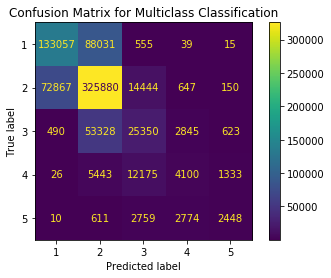

<Figure size 1080x432 with 0 Axes>

In [21]:
# define confusion matrix
cm = confusion_matrix(y, y_pred, labels=log_reg.classes_)
# define confusion matrix display 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
# plot display
disp.plot()
plt.title('Confusion Matrix for Multiclass Classification')
plt.figure(figsize=(15, 6))
plt.show()

In [22]:
y_pred = log_reg.predict(test_X)
print('Test Accuracy score: ', metrics.accuracy_score(test_y, y_pred))

Test Accuracy score:  0.6535


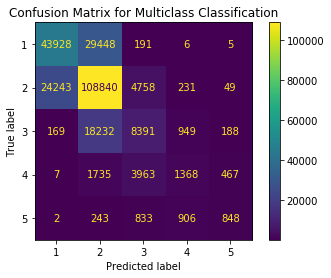

<Figure size 1080x432 with 0 Axes>

In [23]:
# define confusion matrix
cm = confusion_matrix(y, y_pred, labels=log_reg.classes_)
# define confusion matrix display 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
# plot display
disp.plot()
plt.title('Confusion Matrix for Multiclass Classification')
plt.figure(figsize=(15, 6))
plt.show()